In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist,pdist
from scipy.linalg import svd



def interpolate_surface(X, Y, RBF_function, epsilon=1e-6):
    # Create a grid of points for interpolation
    x_max, y_max = np.max(X), np.max(Y)

    x_min, y_min = np.min(X), np.min(Y)
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.column_stack((x_grid.ravel(), y_grid.ravel()))

    m = grid_points.shape[0]

    # Compute the distance matrix between data points and grid points
    dist_matrix = cdist(X, X)

    # Add epsilon to the diagonal of the distance matrix to avoid singularities
    np.fill_diagonal(dist_matrix, epsilon)

    # Compute the RBF matrix
    RBF_matrix = RBF_function(dist_matrix)

    # Solve for the coefficients using linear equations (Ax = Y)
    coefficients = np.linalg.solve(RBF_matrix, Y)

    # Interpolate values for the grid points
    interpolated_values = np.zeros(m)

    for i in range(m):
        distances = np.linalg.norm(X - grid_points[i], axis=1)
        interpolated_values[i] = np.sum(coefficients * RBF_function(distances))

    return x_grid, y_grid, interpolated_values


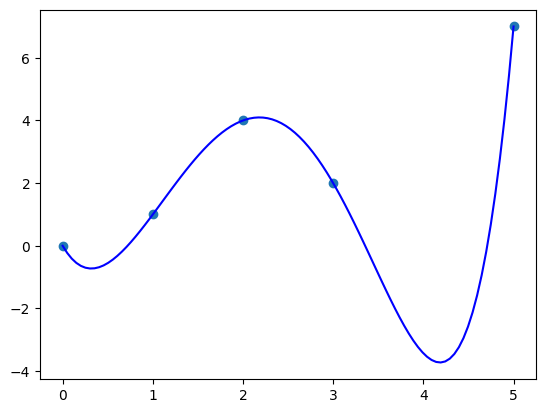

In [48]:
def solve_SVD_system(A, b):
    """
    Solve an underdetermined system Ax = b using SVD.

    Parameters:
    A (numpy.ndarray): The coefficient matrix (m x n) where m < n.
    b (numpy.ndarray): The right-hand side vector (m x 1).

    Returns:
    x (numpy.ndarray): The solution vector that minimizes ||Ax - b||2.
    """
    # Perform singular value decomposition (SVD) of A
    U, S, Vt = np.linalg.svd(A, full_matrices=False)

    # Calculate the pseudo-inverse of A using the SVD components
    S_pseudo = np.diag(1.0 / S)
    A_pseudo = Vt.T @ S_pseudo @ U.T

    # Solve for x using the pseudo-inverse
    x = A_pseudo @ b

    return x



## Define the Cubic function and its integration form


def cubic_double_integration(r):
    return 1/20 * r ** 5

def cubic_integration(r):
    return 1/4*r**4

def cubic_rbf(r):
    return r**3


def IRBFN_cubic_1d(X,Y,g,h,H,epsilon = 1e-6):
    '''
    Function for Indirect Radial basis function network
    args:
    X: set of center points
    Y: target function evaluated at X
    g: radial basis function
    h: Primitive of the rbf
    H: Primitive of h
    epsilon: staiblity control term
    '''
    # Create a grid of points for interpolation
    x_max, y_max = np.max(X), np.max(Y)

    x_min = np.min(X)
    x_grid= np.linspace(x_min, x_max, 100)

    n = Y.shape[0]
    m = x_grid.shape[0]

    X_2d = np.hstack((X.reshape(-1,1),np.zeros((n,1))))
    dist_matrix = cdist(X_2d,X_2d)

    # Add epsilon to the diagonal of the distance matrix to avoid singularities
    np.fill_diagonal(dist_matrix, epsilon)

    # Compute the RBF matrix
    RBF_matrix = H(dist_matrix)

    #Add columns for constant C1 and C2
    constant_matrix = np.hstack((X.reshape(-1,1),np.ones(n).reshape(-1,1)))

    full_matrix = np.hstack((RBF_matrix,constant_matrix))
    # Solve for the coefficients using linear equations (Ax = Y)
    coefficients = solve_SVD_system(full_matrix, Y)

    # Interpolate values for the grid points
    interpolated_values = np.zeros(m)
    # Interpolate values for the first derivative grid points
    interpolated_values_x = np.zeros(m)
    # Interpolate values for the seconde derivative grid points
    interpolated_values_xx = np.zeros(m)

    for i in range(m):
        distances = np.abs(X - x_grid[i])
        H_i = np.hstack((H(distances),x_grid[i],1))
        h_i = np.hstack((h(distances),1))
        g_i = g(distances)
        interpolated_values[i] = np.sum(coefficients * H_i)
        interpolated_values_x[i] = np.sum(coefficients[:-1] * h_i)
        interpolated_values_xx[i] = np.sum(coefficients[:-2] * g_i)

    return x_grid, interpolated_values,interpolated_values_x,interpolated_values_xx


# Sample data points and values
X = np.array([0, 1, 2,3,5])
Y = np.array([0, 1, 4, 2,7])


# Interpolate the surface
x_grid, interpolated_values,interpolated_values_x,interpolated_values_xx = IRBFN_cubic_1d(X, Y,cubic_rbf,cubic_integration,cubic_double_integration)

plt.scatter(X,Y)
plt.plot(x_grid,interpolated_values,c='b')
# plt.plot(x_grid,interpolated_values_x,c='r')
# plt.plot(x_grid,interpolated_values_xx,c='g')

In [46]:
interpolated_values_xx

array([ 2.05455963e+01,  1.89190924e+01,  1.73815619e+01,  1.59295161e+01,
        1.45594662e+01,  1.32679235e+01,  1.20513991e+01,  1.09064044e+01,
        9.82945056e+00,  8.81704881e+00,  7.86571040e+00,  6.97194657e+00,
        6.13226856e+00,  5.34318760e+00,  4.60121493e+00,  3.90286178e+00,
        3.24463941e+00,  2.62305903e+00,  2.03463190e+00,  1.47586925e+00,
        9.43286188e-01,  4.34220007e-01, -5.21576416e-02, -5.16426904e-01,
       -9.59167926e-01, -1.38096085e+00, -1.78238583e+00, -2.16402300e+00,
       -2.52645251e+00, -2.87025450e+00, -3.19600913e+00, -3.50429654e+00,
       -3.79569686e+00, -4.07079025e+00, -4.33015686e+00, -4.57437682e+00,
       -4.80403028e+00, -5.01969739e+00, -5.22195830e+00, -5.41139314e+00,
       -5.58856056e+00, -5.75318304e+00, -5.90389688e+00, -6.03926577e+00,
       -6.15785342e+00, -6.25822354e+00, -6.33893982e+00, -6.39856597e+00,
       -6.43566570e+00, -6.44880269e+00, -6.43654067e+00, -6.39744332e+00,
       -6.33007436e+00, -

In [40]:
def calculate_derivative(X, coefficients, RBF_function):
    """
    Calculate the analytical derivative over the same surface for RBF interpolation.

    Parameters:
    X (numpy.ndarray): The input data points, shape (n, 2).
    coefficients (numpy.ndarray): Coefficients for RBF interpolation, shape (n,).
    RBF_function (callable): The radial basis function used for interpolation.

    Returns:
    derivative (numpy.ndarray): The derivative values at each data point, shape (n, 2).
    """

    n = X.shape[0]
    derivative = np.zeros((n, 2))

    for i in range(n):
        derivative_i = np.zeros(2)

        for j in range(n):
            if i != j:
                diff = X[i] - X[j]
                distance = np.linalg.norm(diff)
                derivative_i += coefficients[j] * RBF_function(distance) * diff

        derivative[i] = derivative_i

    return derivative

# Example usage for calculating the derivative
derivative = calculate_derivative(X, coefficients, gaussian_rbf)
print("Derivative Values:")
print(derivative)


IndexError: index 3 is out of bounds for axis 0 with size 3

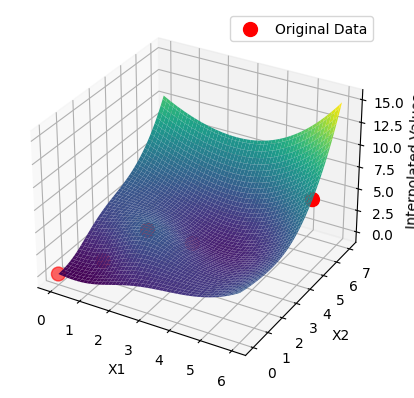

In [61]:

# Sample data points and values
X = np.array([[0, 0], [1, 1], [2, 2],[3,3], [6,5]])
Y = np.array([0, 1, 4, 2,7])



# Interpolate the surface
x_grid, y_grid, interpolated_values = interpolate_surface(X, Y, cubic_rbf)

# Plot the interpolated surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, interpolated_values.reshape(x_grid.shape), cmap='viridis')

# Plot the original data points
ax.scatter(X[:, 0], X[:, 1], Y, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')
plt.legend()
plt.show()


In [20]:
interpolated_points

array([0., 1., 4.])

In [21]:
X[:,1].shape

(3,)